# Data Import - A first look over data

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
import gc  # Import garbage collector interface

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
dataset_path = '/kaggle/input/sncb-remote-diagnostics-in-fleet-maintenance/ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path, delimiter=';')

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17679273 entries, 0 to 17679272
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   mapped_veh_id       float64
 2   timestamps_UTC      object 
 3   lat                 float64
 4   lon                 float64
 5   RS_E_InAirTemp_PC1  float64
 6   RS_E_InAirTemp_PC2  float64
 7   RS_E_OilPress_PC1   float64
 8   RS_E_OilPress_PC2   float64
 9   RS_E_RPM_PC1        float64
 10  RS_E_RPM_PC2        float64
 11  RS_E_WatTemp_PC1    float64
 12  RS_E_WatTemp_PC2    float64
 13  RS_T_OilTemp_PC1    float64
 14  RS_T_OilTemp_PC2    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 2.0+ GB
None
   Unnamed: 0  mapped_veh_id       timestamps_UTC        lat       lon  \
0           0          181.0  2023-08-01 03:44:12  50.769818  3.872114   
1           1          143.0  2023-08-01 06:36:29  51.039993  3.693429   
2           2          183.0  2023

In [3]:
unique_train_id = data.mapped_veh_id.nunique()
print(f"number of unique_train_id: {unique_train_id}")

number of unique_train_id: 92


# Remove Column Unnamed: 0

In [4]:
data.drop(['Unnamed: 0'], axis=1, inplace = True)
data.shape

(17679273, 14)

# Group the data by column mapped_veh_id

In [5]:
data.sort_values(by=['mapped_veh_id', 'timestamps_UTC'], inplace=True)
data

,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
5493376,102.0,2023-01-23 07:25:08,51.017864,3.769079,17.0,18.0,210.0,210.0,858.0,839.0,78.0,80.0,71.0,79.0
8969009,102.0,2023-01-23 07:25:16,51.017875,3.769046,17.0,20.0,200.0,200.0,801.0,804.0,79.0,80.0,76.0,79.0
13873566,102.0,2023-01-23 07:25:37,51.017208,3.770179,19.0,20.0,193.0,207.0,803.0,808.0,80.0,81.0,79.0,81.0
14994675,102.0,2023-01-23 07:25:41,51.016916,3.771036,19.0,20.0,196.0,203.0,801.0,803.0,80.0,81.0,79.0,81.0
11935795,102.0,2023-01-23 07:26:10,51.016503,3.772182,19.0,21.0,200.0,203.0,795.0,807.0,80.0,82.0,79.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820536,197.0,2023-09-13 17:33:03,50.402693,4.450111,37.0,40.0,220.0,258.0,803.0,803.0,81.0,79.0,77.0,81.0
17128255,197.0,2023-09-13 17:33:58,50.401657,4.452693,37.0,38.0,224.0,307.0,843.0,941.0,80.0,78.0,77.0,80.0
15456252,197.0,2023-09-13 17:34:03,50.401830,4.452217,37.0,38.0,224.0,307.0,841.0,932.0,80.0,78.0,77.0,80.0
7666957,197.0,2023-09-13 17:34:58,50.401057,4.455388,36.0,38.0,207.0,244.0,800.0,803.0,81.0,80.0,77.0,82.0


# Distribution of timestamps_UTC

In [6]:
# Convert 'timestamps_UTC' to datetime only once, and drop it immediately after extraction
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])  # Removed errors='coerce' for optimization
data['date'] = data['timestamps_UTC'].dt.date
data['hour'] = data['timestamps_UTC'].dt.hour
data['dayofweek'] = data['timestamps_UTC'].dt.dayofweek
data['weekday'] = data['timestamps_UTC'].dt.strftime('%A')

# Call the garbage collector to free up memory
gc.collect()

0

let's detect is there any outliers in date data

In [7]:
# Set the option to display up to 50 rows to shows all the results
pd.set_option('display.max_rows', 50)

date_distribution = data['date'].value_counts().sort_index()
date_distribution

date
2022-08-22        22
2022-10-14         2
2022-11-08         3
2022-11-21         6
2022-12-19         1
               ...  
2023-09-09     33061
2023-09-10     34621
2023-09-11     99016
2023-09-12    102525
2023-09-13     96949
Name: count, Length: 259, dtype: int64

In [8]:
# Set the option to display up to 50 rows to shows all the results
pd.set_option('display.max_rows', 50)
data[data['date'] == pd.to_datetime('2023-01-05').date()]

,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
6137547,114.0,2023-01-05 02:50:29,51.190382,5.113883,13.0,NaN,307.0,NaN,804.0,NaN,67.0,NaN,56.0,NaN,2023-01-05,2,3,Thursday
11911303,114.0,2023-01-05 02:53:26,51.190377,5.113901,12.0,20.0,293.0,296.0,801.0,796.0,68.0,67.0,60.0,60.0,2023-01-05,2,3,Thursday
8957469,114.0,2023-01-05 02:56:36,51.190362,5.113875,12.0,20.0,289.0,289.0,799.0,801.0,70.0,69.0,61.0,61.0,2023-01-05,2,3,Thursday
2403250,114.0,2023-01-05 02:56:56,51.190385,5.113896,12.0,20.0,284.0,289.5,802.5,797.0,70.0,69.0,60.0,62.0,2023-01-05,2,3,Thursday
3414481,114.0,2023-01-05 02:57:26,51.190394,5.113910,13.0,20.0,286.0,289.0,796.0,804.0,70.0,70.0,62.0,62.0,2023-01-05,2,3,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12881157,127.0,2023-01-05 14:22:31,50.467962,4.840867,37.0,25.0,293.0,296.0,787.0,796.0,75.0,67.0,74.0,68.0,2023-01-05,14,3,Thursday
11914323,127.0,2023-01-05 14:23:30,50.468008,4.840875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,67.0,2023-01-05,14,3,Thursday
8266535,127.0,2023-01-05 14:23:59,50.468357,4.840966,41.0,29.5,3.0,6.0,0.0,0.0,75.0,67.0,74.5,66.0,2023-01-05,14,3,Thursday
395514,127.0,2023-01-05 14:24:01,50.467986,4.840891,41.0,30.0,1.5,6.0,0.0,0.0,75.0,67.0,74.5,65.5,2023-01-05,14,3,Thursday


we can find that the data is uncontinues and almost useless, so let's remove the data of date frequency less than 1000

In [9]:
# Find dates with a frequency of less than 1000
dates_to_remove = date_distribution[date_distribution < 1000].index

# Remove these dates from the DataFrame
data = data[~data['date'].isin(dates_to_remove)]

data.shape

(17677384, 18)

Draw the distribution of date

/tmp/ipykernel_21/1535545806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


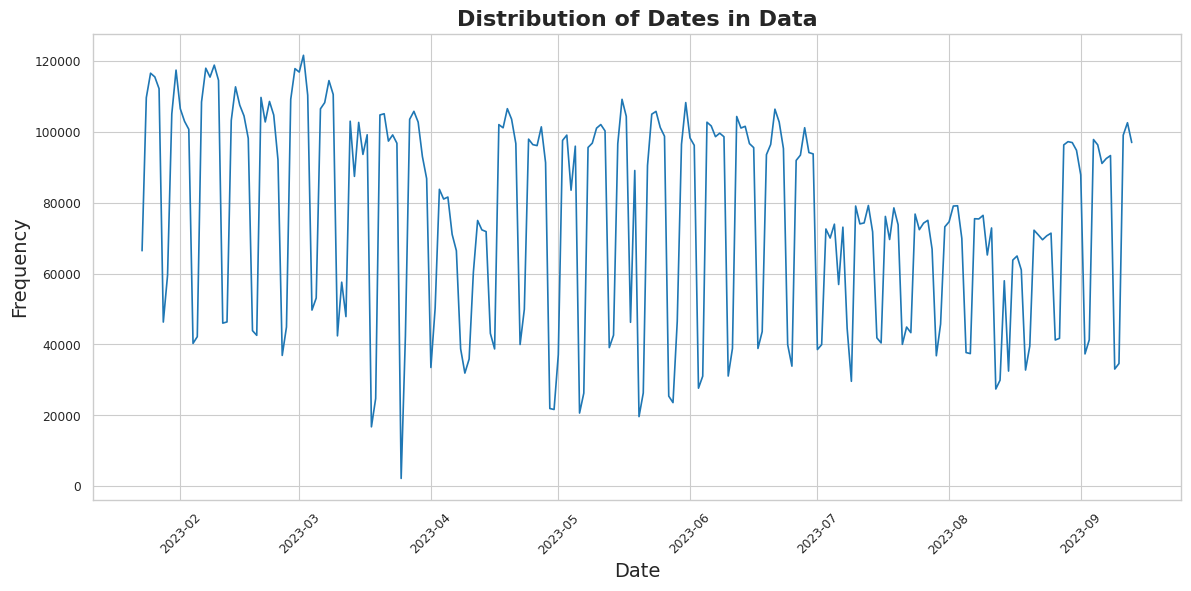

In [10]:
# Convert 'date' to datetime if it's not already
data['date'] = pd.to_datetime(data['date'])

# Count the occurrences of each date
date_counts = data['date'].value_counts().sort_index()

# Set the style of the visualization
sns.set_style("whitegrid")
sns.set_context("paper")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot the distribution of dates
# Using a line plot if you want to see trends over time
sns.lineplot(x=date_counts.index, y=date_counts.values)

# Or using a bar plot if you want to see frequency distribution
# sns.barplot(x=date_counts.index, y=date_counts.values)

# Set title and labels with academic formatting
plt.title('Distribution of Dates in Data', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate date labels to avoid overlap
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

Count the occurrences of each hour and weekday

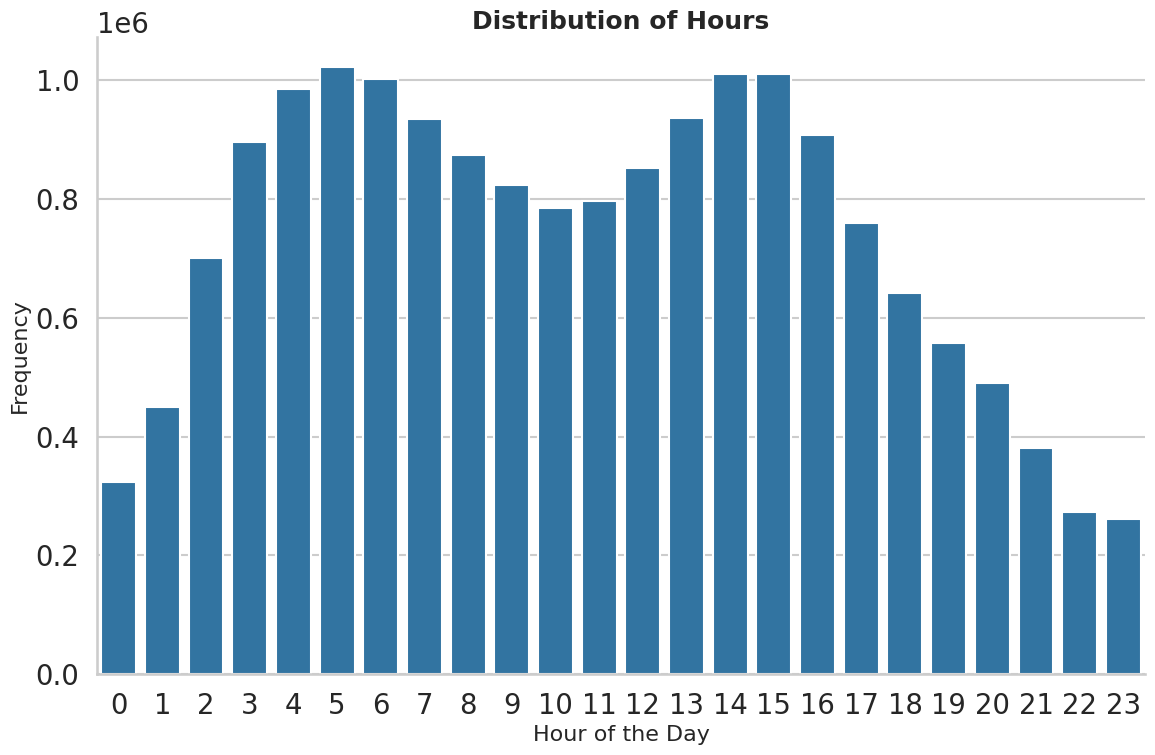

In [11]:
# Calculate the frequency of each hour
hour_counts = data['hour'].value_counts().sort_index()

# Set the style of the visualization
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the bar plot using the default Seaborn blue color
ax = sns.barplot(x=hour_counts.index, y=hour_counts.values, color="C0")

# Set title and labels with academic formatting
plt.title('Distribution of Hours', fontsize=18, weight='bold')
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Frequency', fontsize=16)  # Use 'Frequency' instead of 'Percentage'

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

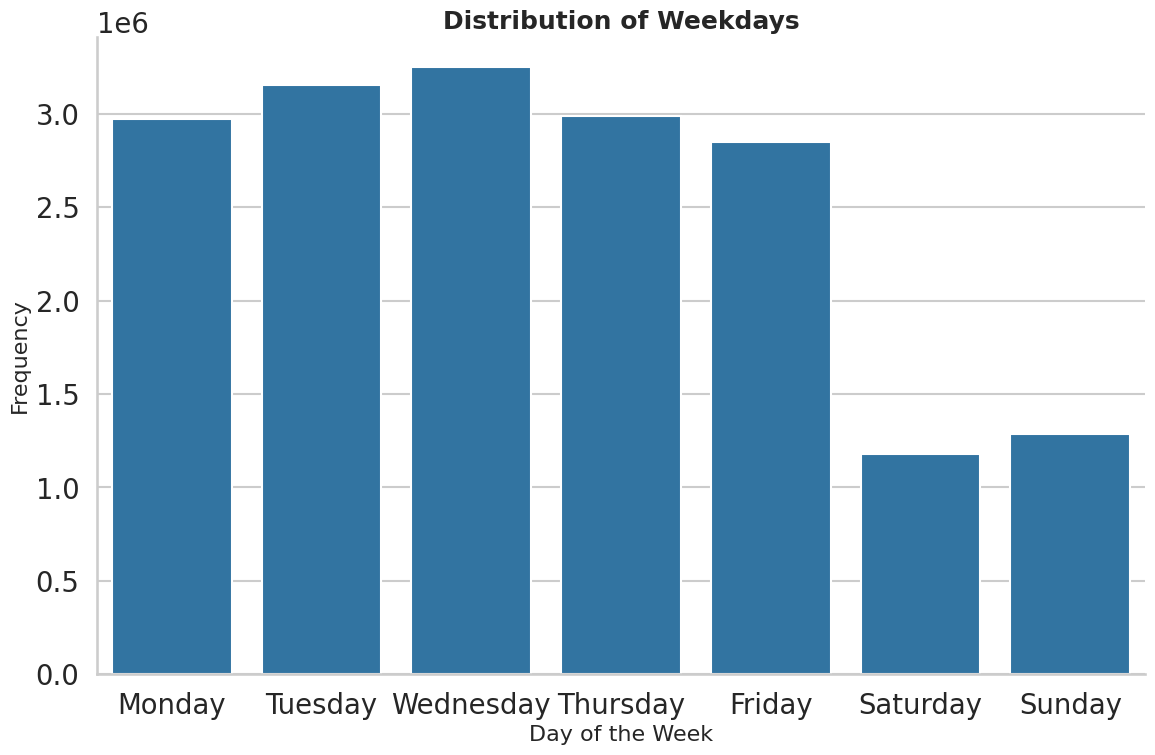

In [12]:
days_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
            4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Copy the 'dayofweek' column and apply the mapping for plotting
mapped_weekdays = data['dayofweek'].map(days_map)

# Calculate the frequency of each day of the week for plotting
weekday_counts = mapped_weekdays.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Plotting the distribution of weekdays
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=weekday_counts.index, y=weekday_counts.values, color="C0")
plt.title('Distribution of Weekdays', fontsize=18, weight='bold')
plt.xlabel('Day of the Week', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

# Diagnose the Missing Value

showing the data with data['mapped_veh_id'] == 102.0 and data == "2023-02-27" to diagnose the Missing Value

| mapped_veh_id | timestamps_UTC | lat       | lon      | RS_E_InAirTemp_PC1 | RS_E_InAirTemp_PC2 | RS_E_OilPress_PC1 | RS_E_OilPress_PC2 | RS_E_RPM_PC1 | RS_E_RPM_PC2 | RS_E_WatTemp_PC1 | RS_E_WatTemp_PC2 | RS_T_OilTemp_PC1 | RS_T_OilTemp_PC2 | date       | time     |
|---------------|----------------|-----------|----------|--------------------|--------------------|-------------------|-------------------|--------------|--------------|------------------|------------------|------------------|------------------|------------|---------|
| 1212149       | 102.0          | 51.014305 | 3.777572 | 5.0                | 1.0                | 486.0             | 465.0             | 798.00       | 802.00       | 40.0              | 44.0              | 28.0              | 34.00             | 2023-02-27 | 05:51:49 |
| 8948897       | 102.0          | 51.013711 | 3.779479 | 5.0                | 1.0                | 483.0             | 465.0             | 797.00       | 800.00       | 41.0              | 45.0              | 28.0              | 35.00             | 2023-02-27 | 05:52:20 |
| 8906016       | 102.0          | 51.013922 | 3.779001 | 0.0                | 1.0                | 0.0               | 131.0             | 0.00         | 0.00         | 0.0               | 45.0              | 26.0              | 34.00             | 2023-02-27 | 05:52:29 |
| 11817588      | 102.0          | 51.013670 | 3.779544 | 0.0                | 1.0                | 120.0             | 148.0             | 0.00         | 211.00       | 0.0               | 45.0              | 26.0              | 35.00             | 2023-02-27 | 05:52:30 |
| 6107927       | 102.0          | 51.013928 | 3.779015 | 0.0                | 0.0                | 0.0               | 0.0               | 0.00         | 0.00         | 0.0               | 0.0               | 24.0              | 34.00             | 2023-02-27 | 05:52:50 |
| 14922602      | 102.0          | 51.013925 | 3.779021 | 0.0                | 0.0                | 0.0               | 0.0               | 0.00         | 0.00         | 40.0              | 0.0               | 28.0              | 35.00             | 2023-02-27 | 05:52:59 |
| 8923184       | 102.0          | 51.013689 | 3.779530 | 7.0                | 3.0                | 0.0               | 0.0               | 0.00         | 0.00         | 40.0              | 0.0               | 25.0              | 34.00             | 2023-02-27 | 05:53:00 |
| 3628039       | 102.0          | 51.013924 | 3.779001 | 8.0                | NaN                | 0.0               | NaN               | 0.00         | NaN          | 40.0              | NaN               | 25.0              | NaN              | 2023-02-27 | 05:53:19 |
| 4831678       | 102.0          | 51.013933 | 3.779009 | 0.0                | NaN                | 0.0               | NaN               | 0.00         | NaN          | 0.0               | NaN               | 25.0              | NaN              | 2023-02-27 | 05:53:29 |
| 10987874      | 102.0          | 51.013939 | 3.779012 | 0.0                | NaN                | 0.0               | NaN               | 0.00         | NaN          | 0.0               | NaN               | 27.0              | NaN              | 2023-02-27 | 05:53:49 |


we can find that the 0 and NaN is also coming together, we assume that the senser should have some bugs at this time

Find a lot of missing values, and the count of them are the same, so let's try to diagnose whether it is caused by systematic problem of senser from PC2

In [13]:
# change pd settings to show 50 rows
pd.set_option('display.max_rows', 50)

data[data.isna().any(axis=1)].sort_values('timestamps_UTC')

,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
10187015,129.0,2023-01-23 08:44:56,51.041364,3.682919,13.0,NaN,310.0,NaN,795.0,NaN,48.0,NaN,47.0,NaN,2023-01-23,8,0,Monday
12877023,186.0,2023-01-23 08:54:11,50.930633,5.328170,37.0,NaN,162.0,NaN,798.0,NaN,77.0,NaN,77.0,NaN,2023-01-23,8,0,Monday
5493281,176.0,2023-01-23 09:49:12,51.177129,3.580304,28.0,NaN,175.0,NaN,790.0,NaN,87.0,NaN,90.0,NaN,2023-01-23,9,0,Monday
11931316,125.0,2023-01-23 10:08:41,50.935218,5.310146,55.0,NaN,3.0,NaN,0.0,NaN,72.0,NaN,13.0,NaN,2023-01-23,10,0,Monday
10342844,181.0,2023-01-23 11:00:08,50.770516,3.872174,35.0,NaN,244.0,NaN,803.0,NaN,81.0,NaN,79.0,NaN,2023-01-23,11,0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13428009,192.0,2023-09-13 14:55:06,50.814124,3.829426,55.0,NaN,262.0,NaN,1689.0,NaN,91.0,NaN,89.0,NaN,2023-09-13,14,2,Wednesday
985293,112.0,2023-09-13 14:58:35,50.906611,3.918921,38.0,NaN,265.0,NaN,802.0,NaN,74.0,NaN,75.0,NaN,2023-09-13,14,2,Wednesday
2269029,170.0,2023-09-13 15:12:22,50.813057,3.830339,43.0,NaN,286.0,NaN,1431.0,NaN,88.0,NaN,92.0,NaN,2023-09-13,15,2,Wednesday
15979145,176.0,2023-09-13 15:58:51,51.032270,3.735101,37.0,NaN,179.0,NaN,800.0,NaN,86.0,NaN,89.0,NaN,2023-09-13,15,2,Wednesday


/tmp/ipykernel_21/1924468944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])


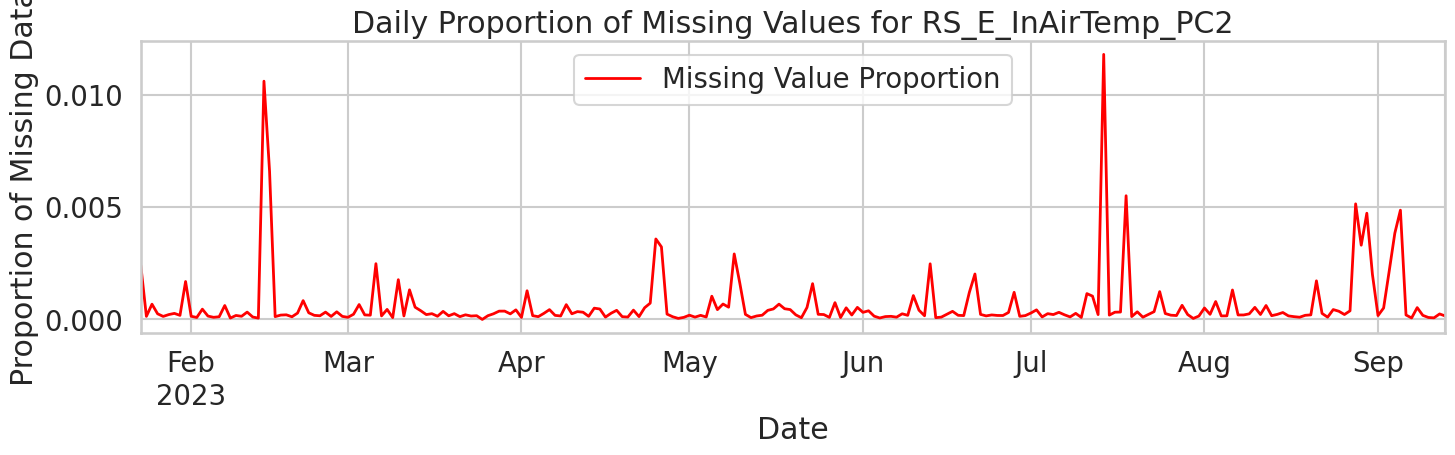

In [14]:
# Make sure 'date' is in datetime format
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# Group by 'date' and calculate the mean of null values for 'RS_E_InAirTemp_PC2'
daily_missing_data = data.groupby(pd.Grouper(key='timestamps_UTC', freq='D'))['RS_E_InAirTemp_PC2'].apply(lambda x: x.isnull().mean())

# Plotting the line plot
plt.figure(figsize=(15, 5))
daily_missing_data.plot(kind='line', color='red', label='Missing Value Proportion', lw=2)
plt.xlabel('Date')
plt.ylabel('Proportion of Missing Data')
plt.title('Daily Proportion of Missing Values for RS_E_InAirTemp_PC2')
plt.legend()
plt.grid(True)  # Adding grid for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

we can see there are a little bit of missing values, but usually less than 1% of overall data, let's handling it together with 0 values

# Interpolate 0 Place Holder

first let's check some 0 values in our data set

In [15]:
# change pd settings to show 50 rows
pd.set_option('display.max_rows', 50)

# change timestamps_UTC to date type
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# set time range
start_time = '2023-02-01 08:00:00'
end_time = '2023-02-01 08:12:00'

# filter time range
data[(data['timestamps_UTC'] >= start_time) & (data['timestamps_UTC'] <= end_time) & (data['mapped_veh_id'] == 160)].sort_values('timestamps_UTC')

/tmp/ipykernel_21/3999435234.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])


,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
6091781,160.0,2023-02-01 08:00:07,51.015991,3.774545,13.0,11.0,241.0,234.0,795.0,800.0,72.0,77.0,77.0,79.0,2023-02-01,8,2,Wednesday
1952708,160.0,2023-02-01 08:00:37,51.016116,3.774187,13.0,12.0,255.0,234.0,809.0,813.0,71.0,76.0,76.0,79.0,2023-02-01,8,2,Wednesday
14932354,160.0,2023-02-01 08:00:41,51.015909,3.774740,13.0,12.0,255.0,234.0,805.0,812.0,71.0,76.0,76.0,79.0,2023-02-01,8,2,Wednesday
4832791,160.0,2023-02-01 08:00:48,51.016112,3.774184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,79.0,2023-02-01,8,2,Wednesday
15937607,160.0,2023-02-01 08:01:00,51.015915,3.774764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,79.0,2023-02-01,8,2,Wednesday
17327401,160.0,2023-02-01 08:01:47,51.016122,3.774188,25.0,23.0,6.0,24.0,0.0,0.0,70.0,76.0,75.0,78.0,2023-02-01,8,2,Wednesday
13807215,160.0,2023-02-01 08:02:01,51.015919,3.774744,27.0,26.0,6.0,24.0,0.0,0.0,70.0,76.0,74.0,77.0,2023-02-01,8,2,Wednesday
8217079,160.0,2023-02-01 08:02:47,51.016134,3.774192,31.0,30.0,6.0,24.0,0.0,0.0,69.0,75.0,74.0,77.0,2023-02-01,8,2,Wednesday
6091780,160.0,2023-02-01 08:03:01,51.015927,3.774770,32.0,31.0,6.0,24.0,0.0,0.0,69.0,75.0,73.0,76.0,2023-02-01,8,2,Wednesday
3359891,160.0,2023-02-01 08:03:51,51.016114,3.774186,35.0,33.0,6.0,24.0,0.0,0.0,68.0,75.0,73.0,77.0,2023-02-01,8,2,Wednesday


we can find that the distribution of 0 value is uncontinues mostly and just occupied a small part of data, so we can make use of linear interpolate to change those data, the 0 values here are more likely to be a place holder, every time the senser read errors or data lost, it put one place holder here

In [16]:
# Replace 0 with NaN in the whole dataset
data.replace(0, np.nan, inplace=True)

# Convert 'timestamps_UTC' to datetime, if not already done
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# Set 'timestamps_UTC' as the index
data.set_index('timestamps_UTC', inplace=True)

# Check for NaN values in the index
if data.index.hasnans:
    raise ValueError("The index contains NaNs, which cannot be present for time interpolation.")

# Interpolate the NaN values in the whole dataset
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[numeric_cols] = data[numeric_cols].interpolate(method='time')

/tmp/ipykernel_21/3146476709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace(0, np.nan, inplace=True)
/tmp/ipykernel_21/3146476709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])
/tmp/ipykernel_21/3146476709.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

and let's check the data again:

In [17]:
# get the column timestamps_UTC from index
data = data.reset_index()

In [18]:
# change pd settings to show 50 rows
pd.set_option('display.max_rows', 50)

# change timestamps_UTC to date type
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# set time range
start_time = '2023-02-01 08:00:00'
end_time = '2023-02-01 08:12:00'

# filter time range
data[(data['timestamps_UTC'] >= start_time) & (data['timestamps_UTC'] <= end_time) & (data['mapped_veh_id'] == 160)].sort_values('timestamps_UTC')

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
10319749,2023-02-01 08:00:07,160.0,51.015991,3.774545,13.0,11.0,241.0,234.0,795.000000,800.000000,72.0,77.0,77.0,79.0,2023-02-01,8.0,2.0,Wednesday
10319750,2023-02-01 08:00:37,160.0,51.016116,3.774187,13.0,12.0,255.0,234.0,809.000000,813.000000,71.0,76.0,76.0,79.0,2023-02-01,8.0,2.0,Wednesday
10319751,2023-02-01 08:00:41,160.0,51.015909,3.774740,13.0,12.0,255.0,234.0,805.000000,812.000000,71.0,76.0,76.0,79.0,2023-02-01,8.0,2.0,Wednesday
10319752,2023-02-01 08:00:48,160.0,51.016112,3.774184,28.0,40.0,345.0,124.0,795.000000,395.500000,81.0,79.0,77.0,79.0,2023-02-01,8.0,2.0,Wednesday
10319753,2023-02-01 08:01:00,160.0,51.015915,3.774764,43.0,43.5,253.0,550.0,1401.000000,1419.000000,77.5,75.5,75.0,79.0,2023-02-01,8.0,2.0,Wednesday
10319754,2023-02-01 08:01:47,160.0,51.016122,3.774188,25.0,23.0,6.0,24.0,1063.500000,825.000000,70.0,76.0,75.0,78.0,2023-02-01,8.0,2.0,Wednesday
10319755,2023-02-01 08:02:01,160.0,51.015919,3.774744,27.0,26.0,6.0,24.0,1082.000000,1449.333333,70.0,76.0,74.0,77.0,2023-02-01,8.0,2.0,Wednesday
10319756,2023-02-01 08:02:47,160.0,51.016134,3.774192,31.0,30.0,6.0,24.0,1159.333333,1132.666667,69.0,75.0,74.0,77.0,2023-02-01,8.0,2.0,Wednesday
10319757,2023-02-01 08:03:01,160.0,51.015927,3.774770,32.0,31.0,6.0,24.0,804.000000,797.250000,69.0,75.0,73.0,76.0,2023-02-01,8.0,2.0,Wednesday
10319758,2023-02-01 08:03:51,160.0,51.016114,3.774186,35.0,33.0,6.0,24.0,799.500000,793.500000,68.0,75.0,73.0,77.0,2023-02-01,8.0,2.0,Wednesday


# Distribution of unique_train_id

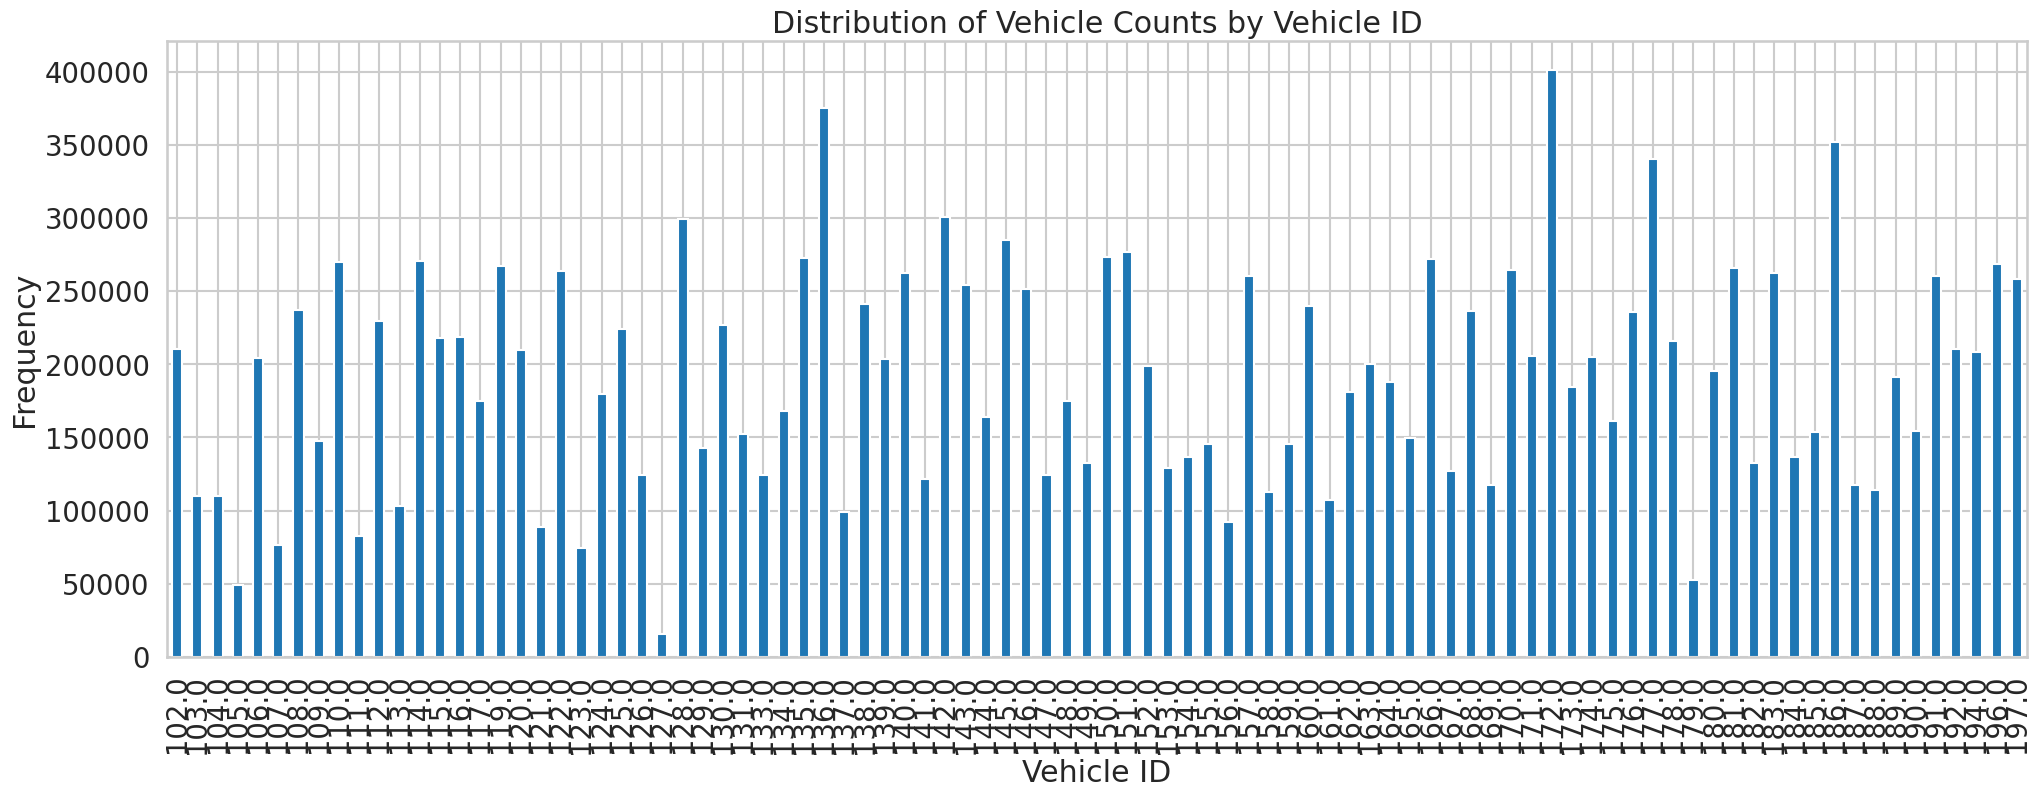

In [19]:
# First, group by 'mapped_veh_id' and count the occurrences
vehicle_counts = data.groupby('mapped_veh_id').size()

# Now, plot the bar chart
vehicle_counts.plot(kind='bar', figsize=(24, 8))

plt.title("Distribution of Vehicle Counts by Vehicle ID")
plt.xlabel("Vehicle ID")
plt.ylabel("Frequency")
plt.show()

# Distribution of RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2

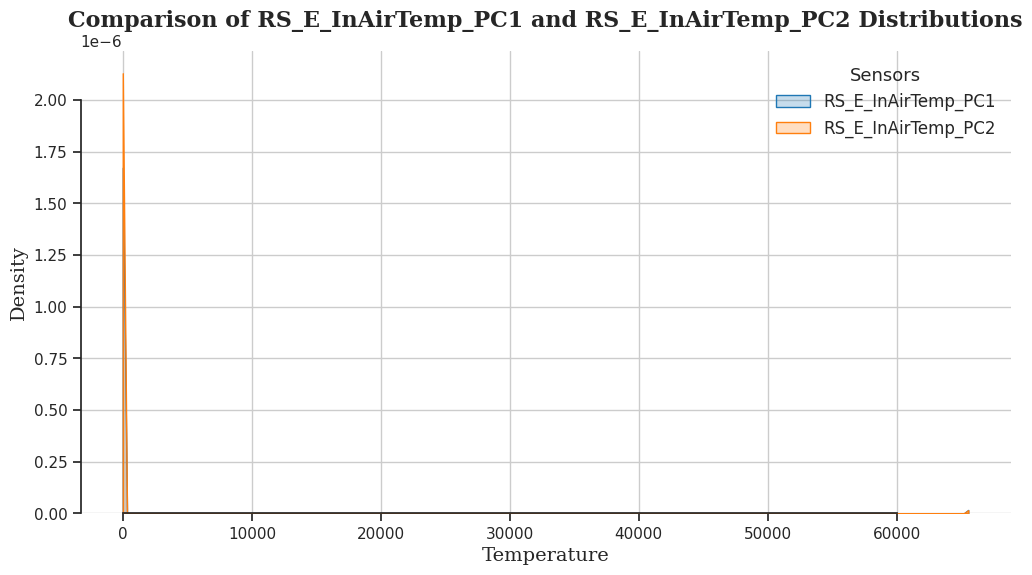

In [20]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_InAirTemp_PC1
sns.kdeplot(data['RS_E_InAirTemp_PC1'], fill=True, color="#1f77b4", label='RS_E_InAirTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_InAirTemp_PC2
sns.kdeplot(data['RS_E_InAirTemp_PC2'], fill=True, color="#ff7f0e", label='RS_E_InAirTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


it seems there exists a very huge values that make this graph hard to tell

In [21]:
# Display the basic statistics for 'RS_E_InAirTemp_PC1' and 'RS_E_InAirTemp_PC2' to identify outliers
stats_pc1 = data['RS_E_InAirTemp_PC1'].describe()
stats_pc2 = data['RS_E_InAirTemp_PC2'].describe()

(stats_pc1, stats_pc2)

(count    1.767738e+07
 mean     3.229394e+01
 std      3.345148e+02
 min      5.813953e-02
 25%      2.200000e+01
 50%      3.200000e+01
 75%      4.000000e+01
 max      6.553500e+04
 Name: RS_E_InAirTemp_PC1, dtype: float64,
 count    1.767738e+07
 mean     3.262397e+01
 std      3.537753e+02
 min      3.333333e-01
 25%      2.200000e+01
 50%      3.300000e+01
 75%      3.900000e+01
 max      6.553500e+04
 Name: RS_E_InAirTemp_PC2, dtype: float64)

In [22]:
data[data['RS_E_InAirTemp_PC1'] > 1000].sort_values('timestamps_UTC').head()

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
17429706,2023-01-28 23:09:24,197.0,50.093630,4.529261,65533.0,52.0,610.0,348.0,799.0,452.5,3.0,3.0,1.0,4.0,2023-01-28,23.0,5.0,Saturday
12402384,2023-01-28 23:09:33,171.0,50.094173,4.528174,65535.0,65534.0,638.0,610.0,801.0,802.0,3.0,5.0,1.0,6.0,2023-01-28,23.0,5.0,Saturday
12402385,2023-01-28 23:09:37,171.0,50.093919,4.528709,65535.0,65534.0,617.0,610.0,798.0,800.0,3.0,5.0,1.0,6.0,2023-01-28,23.0,5.0,Saturday
4834839,2023-01-28 23:09:43,131.0,50.093910,4.528723,65535.0,65535.0,655.0,690.0,801.0,801.0,4.0,6.0,1.0,4.0,2023-01-28,23.0,5.0,Saturday
17429707,2023-01-28 23:10:14,197.0,50.093621,4.529263,65533.0,1.0,638.0,10.0,802.0,796.0,6.0,3.0,63.0,4.0,2023-01-28,23.0,5.0,Saturday


In [23]:
data[data['RS_E_InAirTemp_PC2'] > 1000].sort_values('timestamps_UTC').head()

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
3798540,2023-01-24 00:37:18,125.0,50.936568,5.306207,45.0,65519.0,3.0,690.0,803.0,663.0,65.0,-17.0,50.0,67.0,2023-01-24,9.32482,1.0,Tuesday
9700704,2023-01-25 14:14:41,156.0,51.014321,3.779286,2.0,65535.0,593.0,579.0,802.0,797.0,19.0,15.0,16.0,11.0,2023-01-25,14.00000,2.0,Wednesday
9700705,2023-01-25 14:14:54,156.0,51.014146,3.779875,2.0,65535.0,579.0,593.0,796.0,802.0,20.0,15.0,14.0,11.0,2023-01-25,14.00000,2.0,Wednesday
9700707,2023-01-25 14:15:55,156.0,51.014145,3.779855,2.0,65535.0,572.0,589.0,797.0,804.0,23.0,17.0,15.0,12.0,2023-01-25,14.00000,2.0,Wednesday
9700831,2023-01-25 15:16:47,156.0,51.023516,3.758755,11.0,65535.0,434.0,472.0,879.0,872.0,52.0,48.0,52.0,47.0,2023-01-25,15.00000,2.0,Wednesday


the very huge temperature is not possible in the real world, and it coincidently to be the value of $2^16$ - 1, which is the maximum value for an unsigned 16-bit integer. And the other normal temperature in the near time is about 1 or 2 which is near to 0, so it is reasonable the temperature below 0 here, so we can solve this problem by make those data right 

In [24]:
# Minus 65536 to those abnormal data to make it right
data.loc[data['RS_E_InAirTemp_PC1'] > 65000, 'RS_E_InAirTemp_PC1'] -= 65536
data.loc[data['RS_E_InAirTemp_PC2'] > 65000, 'RS_E_InAirTemp_PC2'] -= 65536

In [25]:
# From the provided screenshot, it seems the user attempted to subtract 65536 from the outlier values directly in the condition statement.
# The correction should be applied to the dataframe itself. Let's apply the correction properly.

# Correcting the abnormal values by subtracting 65536 directly in the dataframe
data.loc[data['RS_E_InAirTemp_PC1'] > 65000, 'RS_E_InAirTemp_PC1'] -= 65536
data.loc[data['RS_E_InAirTemp_PC2'] > 65000, 'RS_E_InAirTemp_PC2'] -= 65536

# Let's check if the data has been updated by looking at the maximum values now
max_value_pc1_updated = data['RS_E_InAirTemp_PC1'].max()
max_value_pc2_updated = data['RS_E_InAirTemp_PC2'].max()

max_value_pc1_updated, max_value_pc2_updated

(52434.600000000006, 49150.5)

but there are still some temperature larger than 30000 degree, let's figure out the reason behind this:

In [26]:
data.loc[data['RS_E_InAirTemp_PC1'] > 30000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
214309,2023-01-29 06:14:50,103.0,50.094416,4.527734,32784.000000,32786.00,238.0,251.000000,800.0,799.0,75.0,75.0,74.0,72.0,2023-01-29,6.0,6.0,Sunday
531447,2023-03-01 03:10:02,106.0,50.094359,4.527792,32767.500000,13.00,349.5,313.500000,800.0,799.0,48.0,64.0,51.0,61.5,2023-03-01,3.0,2.0,Wednesday
2755013,2023-02-26 21:36:56,119.0,51.015913,3.774808,32773.000000,13.25,325.5,444.500000,790.0,796.5,40.5,35.0,12.0,69.0,2023-02-26,21.0,6.0,Sunday
4987115,2023-01-29 09:12:21,133.0,50.401060,4.456639,32765.500000,32767.00,6.5,320.500000,1837.0,399.5,90.0,77.0,73.0,73.0,2023-01-29,9.0,6.0,Sunday
6871623,2023-01-29 03:12:43,142.0,51.190537,5.112477,43691.000000,15.00,207.0,235.666667,804.0,796.0,78.0,19.0,76.0,17.0,2023-01-29,3.0,6.0,Sunday
6871627,2023-01-29 03:14:44,142.0,51.190519,5.112460,43693.333333,15.00,213.0,236.666667,803.0,796.0,78.0,19.0,74.0,17.0,2023-01-29,3.0,6.0,Sunday
8973171,2023-06-15 13:34:23,151.0,51.013158,3.780460,32759.500000,28.50,382.0,3.000000,1673.0,1690.0,-8.5,27.0,16.5,27.5,2023-06-15,13.0,3.0,Thursday
8973190,2023-06-16 11:02:14,151.0,51.012935,3.780610,32771.500000,25.00,284.5,3.000000,898.5,794.0,25.0,23.0,10.0,24.0,2023-06-16,11.0,4.0,Friday
8973359,2023-06-16 13:19:44,151.0,51.013180,3.781200,32760.500000,25.00,6.5,3.000000,385.0,1252.5,24.5,23.0,40.0,24.0,2023-06-16,13.0,4.0,Friday
9104384,2023-02-26 06:27:29,152.0,50.095749,4.524782,39334.200000,31.70,520.0,589.000000,798.0,799.0,18.0,17.0,4.0,6.0,2023-02-26,6.0,6.0,Sunday


In [27]:
data.loc[data['RS_E_InAirTemp_PC2'] > 30000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
214309,2023-01-29 06:14:50,103.0,50.094416,4.527734,32784.0,32786.0,238.0,251.0,800.000000,799.00,75.0,75.000000,74.0,72.0,2023-01-29,6.0,6.0,Sunday
214310,2023-01-29 06:15:50,103.0,50.094405,4.527735,10.0,32767.5,234.0,258.0,798.000000,800.00,75.0,75.000000,73.0,73.0,2023-01-29,6.0,6.0,Sunday
214319,2023-01-29 06:24:47,103.0,50.094413,4.527718,39.0,32785.5,238.0,251.0,800.000000,801.00,75.0,75.000000,73.0,74.0,2023-01-29,6.0,6.0,Sunday
1163155,2023-02-08 06:07:26,110.0,51.011785,3.781229,3.0,32786.0,638.0,589.0,1342.000000,1483.00,32.0,38.000000,19.0,18.0,2023-02-08,6.0,2.0,Wednesday
2113633,2023-01-29 06:02:01,115.0,50.400862,4.457522,10.5,49150.5,552.0,579.0,800.000000,802.00,11.0,12.000000,6.0,6.0,2023-01-29,6.0,6.0,Sunday
4631157,2023-02-08 03:46:11,130.0,51.191021,5.114999,2.0,32767.0,373.5,410.0,852.500000,898.50,53.0,53.000000,51.5,48.5,2023-02-08,3.0,2.0,Wednesday
4987115,2023-01-29 09:12:21,133.0,50.401060,4.456639,32765.5,32767.0,6.5,320.5,1837.000000,399.50,90.0,77.000000,73.0,73.0,2023-01-29,9.0,6.0,Sunday
9700832,2023-01-25 15:16:48,156.0,51.023798,3.758218,12.0,32768.0,494.5,527.5,1270.000000,1244.50,52.0,48.000000,51.0,46.0,2023-01-25,15.0,2.0,Wednesday
10316005,2023-01-29 02:42:03,160.0,50.855218,3.606301,3.5,32770.0,538.0,545.0,802.000000,801.00,22.0,28.000000,9.0,8.0,2023-01-29,2.0,6.0,Sunday
10610908,2023-05-16 23:15:27,161.0,51.013925,3.780516,47.0,32759.5,138.0,3.0,799.428571,802.25,76.0,30.000000,73.5,65.5,2023-05-16,23.0,1.0,Tuesday


it is interesting that the temperature is around 32765, and we find out that 65536 / 2 is 32768, so it is still becuase the minus temperature rolled over, and the reason it is around 32765 some times with a decimal 0.5, it is because it was 16 unsigned bits, but in order to save the decimal numbers, it becomes to $11111111$.$10000000$,8 bits for integers and 8 bits for decimals

so the solution for this should be: minus 0.5 of those data, multiple it with 2, minus 65536, and add 0.5 back

but data 32775.0 is an error here because the result of it is $(32775.0 - 0.5）* 2 - 65536 = 13$, so let's remove this line

In [28]:
# Remove the row with the specific erroneous value mentioned in the analysis
data = data[data['RS_E_InAirTemp_PC1'] != 32775.0]

# Apply the correction to RS_E_InAirTemp_PC1
data.loc[data['RS_E_InAirTemp_PC1'] > 32700, 'RS_E_InAirTemp_PC1'] = (data['RS_E_InAirTemp_PC1'] - 0.5) * 2 - 65536 + 0.5

# Apply the correction to RS_E_InAirTemp_PC2
data.loc[data['RS_E_InAirTemp_PC2'] > 32700, 'RS_E_InAirTemp_PC2'] = (data['RS_E_InAirTemp_PC2'] - 0.5) * 2 - 65536 + 0.5


# Let's check if the data has been updated by looking at the maximum values now
max_value_pc1_updated = data['RS_E_InAirTemp_PC1'].max()
max_value_pc2_updated = data['RS_E_InAirTemp_PC2'].max()

max_value_pc1_updated, max_value_pc2_updated

(39332.70000000001, 32764.5)

and now we get a new outlier 21839.666666666668, let's figure out the reason:

In [29]:
data.loc[data['RS_E_InAirTemp_PC1'] > 1000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
2113640,2023-01-29 06:05:55,115.0,50.400908,4.457507,21847.333333,21849.666667,517.0,562.000000,798.0,798.0,23.0,28.0,9.0,10.0,2023-01-29,6.0,6.0,Sunday
6871623,2023-01-29 03:12:43,142.0,51.190537,5.112477,21845.500000,15.000000,207.0,235.666667,804.0,796.0,78.0,19.0,76.0,17.0,2023-01-29,3.0,6.0,Sunday
6871627,2023-01-29 03:14:44,142.0,51.190519,5.112460,21850.166667,15.000000,213.0,236.666667,803.0,796.0,78.0,19.0,74.0,17.0,2023-01-29,3.0,6.0,Sunday
9104384,2023-02-26 06:27:29,152.0,50.095749,4.524782,13131.900000,31.700000,520.0,589.000000,798.0,799.0,18.0,17.0,4.0,6.0,2023-02-26,6.0,6.0,Sunday
9104385,2023-02-26 06:27:30,152.0,50.095487,4.525251,39332.700000,30.600000,531.0,586.000000,803.0,804.0,18.0,17.0,6.0,5.0,2023-02-26,6.0,6.0,Sunday


In [30]:
data.loc[data['RS_E_InAirTemp_PC2'] > 1000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
2113633,2023-01-29 06:02:01,115.0,50.400862,4.457522,10.500000,32764.500000,552.000000,579.0,800.000000,802.000000,11.000000,12.000000,6.000000,6.000000,2023-01-29,6.0,6.0,Sunday
2113640,2023-01-29 06:05:55,115.0,50.400908,4.457507,21847.333333,21849.666667,517.000000,562.0,798.000000,798.000000,23.000000,28.000000,9.000000,10.000000,2023-01-29,6.0,6.0,Sunday
4631105,2023-02-08 03:17:16,130.0,51.191030,5.114860,1.000000,21856.333333,358.000000,341.0,799.000000,801.000000,52.000000,53.000000,50.000000,49.000000,2023-02-08,3.0,2.0,Wednesday
11185570,2023-08-05 06:28:14,164.0,51.038786,5.275683,37.666667,21839.666667,386.666667,312.0,1708.333333,1158.666667,83.333333,27.333333,85.333333,86.666667,2023-08-05,6.0,5.0,Saturday


it is weired, $21839 * 3 - 65536 = -19$, we can not assure it is conincidence or by some reason, but it is totally safe to remove this outlier, so let's remove it

In [31]:
# Remove the row with the specific erroneous value mentioned in the analysis
data = data[data['RS_E_InAirTemp_PC1'] < 1000]
data = data[data['RS_E_InAirTemp_PC2'] < 1000]

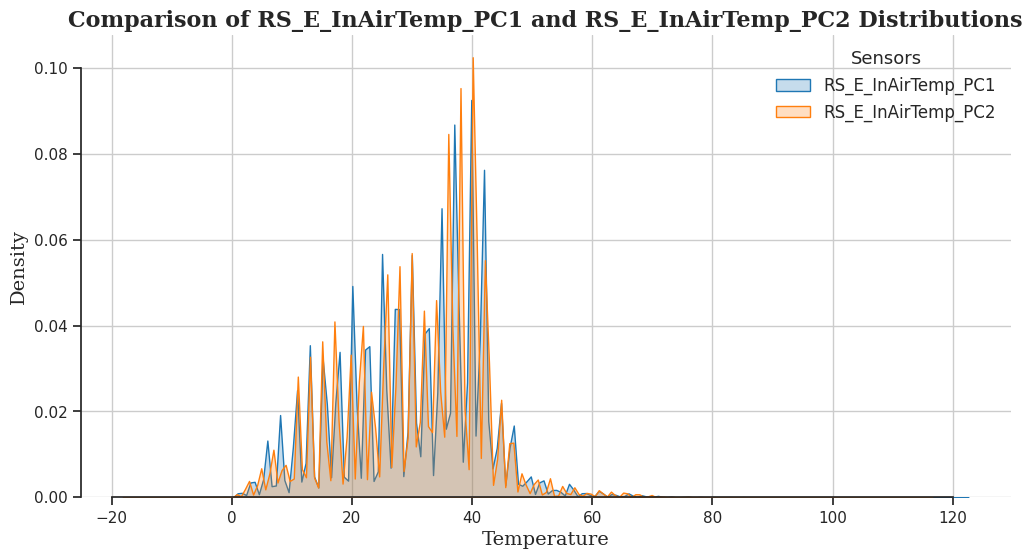

In [32]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_InAirTemp_PC1
sns.kdeplot(data['RS_E_InAirTemp_PC1'], fill=True, color="#1f77b4", label='RS_E_InAirTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_InAirTemp_PC2
sns.kdeplot(data['RS_E_InAirTemp_PC2'], fill=True, color="#ff7f0e", label='RS_E_InAirTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


the graph seems more reasonable now, but let's check more detailed where is the data larger than 100

In [33]:
data.loc[data['RS_E_InAirTemp_PC1'] > 90]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
4420200,2023-08-18 14:05:30,128.0,50.930459,5.327558,91.0,36.0,10.0,189.0,801.0,799.0,95.0,73.0,92.0,86.0,2023-08-18,14.0,4.000000,Friday
4420201,2023-08-18 14:06:28,128.0,50.930632,5.326918,91.0,36.0,10.0,189.0,787.0,802.0,94.0,73.0,92.0,85.0,2023-08-18,14.0,4.000000,Friday
4420202,2023-08-18 14:06:33,128.0,50.930469,5.327587,91.0,36.0,10.0,193.0,800.0,797.0,94.0,73.0,90.0,85.0,2023-08-18,14.0,4.000000,Friday
4420203,2023-08-18 14:07:28,128.0,50.930630,5.326952,91.0,36.0,10.0,196.0,802.0,800.0,93.0,73.0,90.0,85.0,2023-08-18,14.0,4.000000,Friday
4420204,2023-08-18 14:07:32,128.0,50.930490,5.327528,91.0,36.0,10.0,189.0,794.0,794.0,94.0,73.0,89.0,84.0,2023-08-18,14.0,4.000000,Friday
4420205,2023-08-18 14:08:29,128.0,50.930715,5.326633,91.0,36.0,10.0,369.0,796.0,1699.0,93.0,73.0,90.0,85.0,2023-08-18,14.0,4.000000,Friday
4420206,2023-08-18 14:08:33,128.0,50.930634,5.326947,91.0,36.0,10.0,369.0,1079.5,1703.0,93.0,73.0,90.0,84.0,2023-08-18,14.0,4.000000,Friday
4420207,2023-08-18 14:09:23,128.0,50.932252,5.321323,91.0,37.0,10.0,186.0,798.0,829.0,93.0,76.0,90.0,86.0,2023-08-18,14.0,4.000000,Friday
4420208,2023-08-18 14:09:28,128.0,50.932629,5.320049,91.0,37.0,10.0,179.0,798.0,778.0,93.0,76.0,90.0,86.0,2023-08-18,14.0,4.000000,Friday
17021443,2023-04-03 14:24:04,194.0,50.893255,3.810035,122.0,40.0,496.0,286.0,1339.0,954.0,77.0,82.0,77.0,82.0,2023-04-03,14.0,2.999815,Monday


In [34]:
data.loc[data['RS_E_InAirTemp_PC2'] > 90]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
4333475,2023-06-23 16:11:04,128.0,51.168052,4.968098,44.0,91.0,351.0,3.0,1535.0,800.00,90.0,91.000000,87.0,101.0,2023-06-23,16.0,4.0,Friday
4333476,2023-06-23 16:11:05,128.0,51.168021,4.968404,44.0,91.0,362.0,3.0,1506.0,1346.00,90.0,91.000000,89.0,101.0,2023-06-23,16.0,4.0,Friday
4333477,2023-06-23 16:12:04,128.0,51.170230,4.944232,44.0,91.0,369.0,3.0,1914.0,796.00,90.0,91.000000,88.0,100.0,2023-06-23,16.0,4.0,Friday
4333478,2023-06-23 16:12:05,128.0,51.170203,4.944445,43.0,91.0,372.0,3.0,1901.0,1358.00,90.0,91.000000,87.0,101.0,2023-06-23,16.0,4.0,Friday
4333479,2023-06-23 16:13:07,128.0,51.172814,4.915847,42.0,92.0,362.0,3.0,1500.0,1882.00,87.0,90.000000,87.0,100.0,2023-06-23,16.0,4.0,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4456907,2023-09-06 16:04:15,128.0,51.185951,5.088301,41.0,91.0,317.0,3.0,1468.0,1856.00,80.0,83.000000,79.0,95.0,2023-09-06,16.0,2.0,Wednesday
4456908,2023-09-06 16:04:18,128.0,51.185714,5.086965,41.0,91.0,362.0,3.0,1300.0,1908.00,80.0,83.000000,77.0,95.0,2023-09-06,16.0,2.0,Wednesday
4456909,2023-09-06 16:05:08,128.0,51.183120,5.072290,41.0,91.0,386.0,3.0,1743.0,1257.25,82.0,82.000000,80.0,94.0,2023-09-06,16.0,2.0,Wednesday
4456910,2023-09-06 16:05:18,128.0,51.182308,5.067683,41.0,91.0,396.0,3.0,1790.0,1848.00,82.0,82.000000,80.0,95.0,2023-09-06,16.0,2.0,Wednesday


it may be the correct data, there may exist some engineer problems when the temperature is unreasonablely high, so we will figure this out in the next step

but we noticed that there are some temperature -20 in the data which is ubnormal, so let's check what is it

In [35]:
data.loc[data['RS_E_InAirTemp_PC1'] < -5]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
2044696,2023-06-30 12:33:28,114.0,50.936668,5.306341,-17.0,41.0,213.0,186.0,796.0,799.0,80.0,80.0,74.0,76.0,2023-06-30,12.0,4.0,Friday
2044697,2023-06-30 12:33:34,114.0,50.936747,5.305696,-17.0,41.0,196.0,211.5,797.0,808.5,80.0,80.0,76.0,76.0,2023-06-30,12.0,4.0,Friday
4987115,2023-01-29 09:12:21,133.0,50.401060,4.456639,-5.5,-2.5,6.5,320.5,1837.0,399.5,90.0,77.0,73.0,73.0,2023-01-29,9.0,6.0,Sunday
8973171,2023-06-15 13:34:23,151.0,51.013158,3.780460,-17.5,28.5,382.0,3.0,1673.0,1690.0,-8.5,27.0,16.5,27.5,2023-06-15,13.0,3.0,Thursday
8973359,2023-06-16 13:19:44,151.0,51.013180,3.781200,-15.5,25.0,6.5,3.0,385.0,1252.5,24.5,23.0,40.0,24.0,2023-06-16,13.0,4.0,Friday
10692798,2023-03-19 10:12:18,162.0,51.013141,3.781080,-17.5,23.0,310.0,3.0,1327.0,1331.0,29.0,22.0,58.0,20.5,2023-03-19,10.0,6.0,Sunday
11995487,2023-08-23 09:04:36,168.0,51.013408,3.780621,-17.0,63.0,3.0,10.0,797.0,801.0,43.0,66.0,32.0,66.5,2023-08-23,9.0,2.0,Wednesday


In [36]:
data.loc[data['RS_E_InAirTemp_PC2'] < -5]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
3798540,2023-01-24 00:37:18,125.0,50.936568,5.306207,45.0,-17.0,3.0,690.000000,803.000000,663.000000,65.0,-17.000000,50.0,67.000000,2023-01-24,9.32482,1.000000,Tuesday
3801260,2023-01-27 09:54:12,125.0,51.168846,4.988125,38.0,-17.0,348.0,690.000000,1498.000000,801.000000,84.0,-17.000000,88.0,74.000000,2023-01-27,9.00000,4.000000,Friday
3805359,2023-01-29 08:18:45,125.0,51.119022,5.257582,38.0,-17.0,341.0,373.333333,1498.000000,1283.666667,81.0,-17.000000,86.0,81.000000,2023-01-29,8.00000,6.000000,Sunday
3805921,2023-01-29 13:19:52,125.0,51.245551,5.536129,17.0,-17.0,403.0,310.000000,1929.000000,1680.000000,77.0,-17.000000,76.0,94.000000,2023-01-29,13.00000,6.000000,Sunday
3806293,2023-01-29 16:32:02,125.0,51.038318,5.281033,37.0,-17.0,334.0,319.333333,1500.000000,1275.000000,83.0,-17.000000,86.0,85.000000,2023-01-29,16.00000,6.000000,Sunday
3807383,2023-01-30 03:40:02,125.0,51.190165,5.112595,15.0,-17.0,248.0,276.000000,794.000000,801.000000,71.0,-17.000000,66.0,60.000000,2023-01-30,3.00000,5.235964,Monday
3808059,2023-01-30 18:41:35,125.0,51.180228,4.826087,35.0,-17.0,203.0,445.000000,830.000000,738.000000,82.0,81.000000,83.0,84.000000,2023-01-30,18.00000,2.105691,Monday
3808536,2023-01-31 17:32:56,125.0,51.091506,5.235144,36.0,-17.0,360.0,238.000000,1500.000000,804.000000,84.5,-17.000000,89.0,84.000000,2023-01-31,17.00000,1.000000,Tuesday
5931203,2023-07-09 18:05:46,137.0,51.190644,5.113072,26.0,-17.0,518.5,210.000000,798.000000,840.000000,36.5,-17.000000,30.5,91.000000,2023-07-09,18.00000,6.000000,Sunday
10283894,2023-08-09 12:50:17,159.0,51.035912,3.709557,28.0,-17.0,203.0,248.000000,803.000000,805.000000,83.0,-17.000000,80.0,43.000000,2023-08-09,12.00000,2.000000,Wednesday


those data are rare and uncontinues, so just delete them is fine

In [37]:
# Remove the row with the specific erroneous value mentioned in the analysis
data = data[data['RS_E_InAirTemp_PC1'] >-6]
data = data[data['RS_E_InAirTemp_PC2'] >-6]

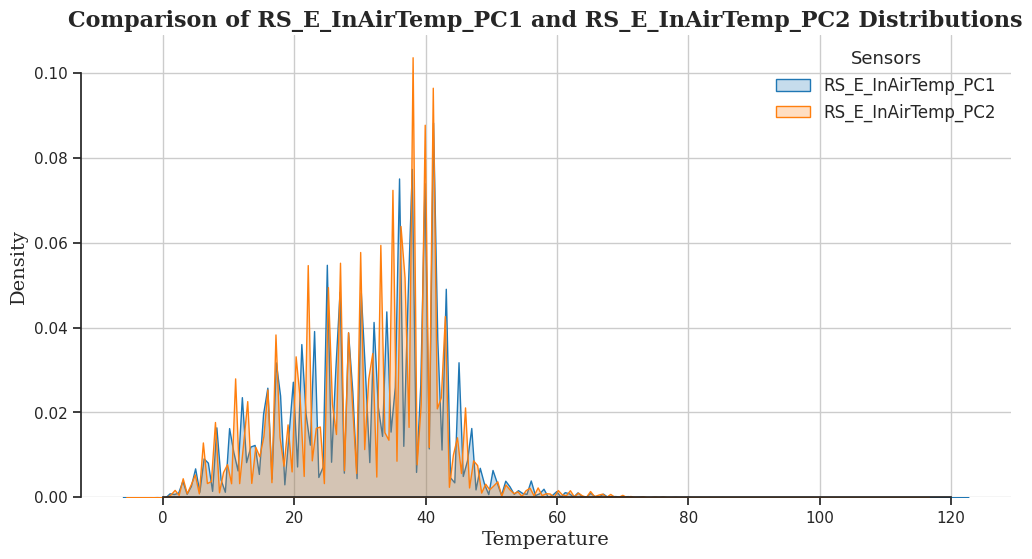

In [38]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_InAirTemp_PC1
sns.kdeplot(data['RS_E_InAirTemp_PC1'], fill=True, color="#1f77b4", label='RS_E_InAirTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_InAirTemp_PC2
sns.kdeplot(data['RS_E_InAirTemp_PC2'], fill=True, color="#ff7f0e", label='RS_E_InAirTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


# Distribution of RS_E_OilPress_PC1 and RS_E_OilPress_PC2

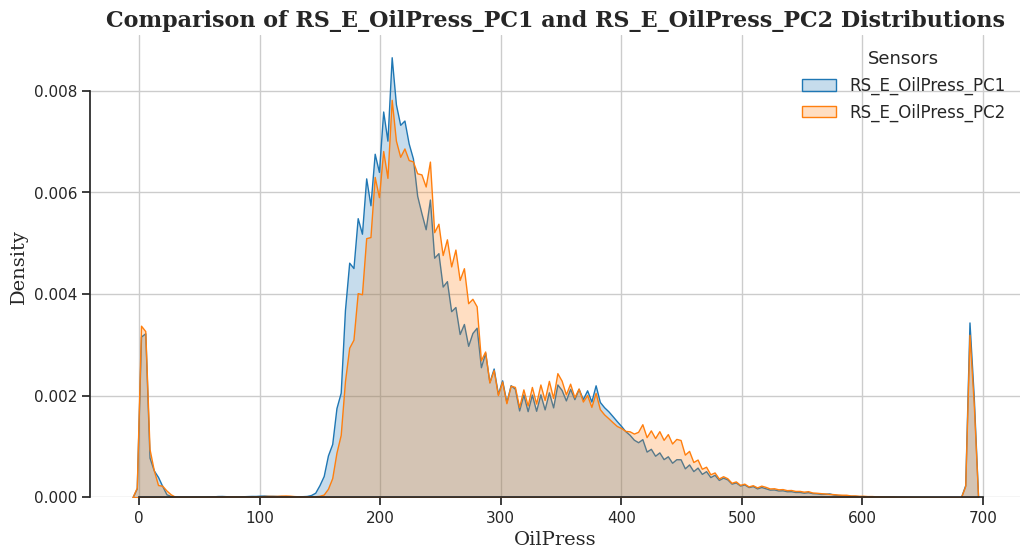

In [39]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_OilPress_PC1
sns.kdeplot(data['RS_E_OilPress_PC1'], fill=True, color="#1f77b4", label='RS_E_OilPress_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_OilPress_PC2
sns.kdeplot(data['RS_E_OilPress_PC2'], fill=True, color="#ff7f0e", label='RS_E_OilPress_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_OilPress_PC1 and RS_E_OilPress_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('OilPress', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


# Distribution of RS_E_RPM_PC1 and RS_E_RPM_PC2 

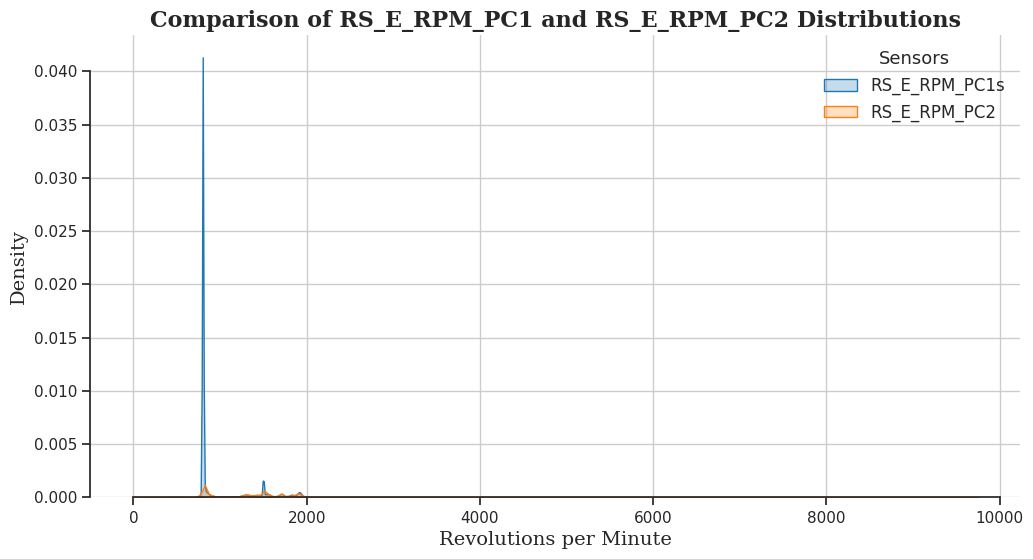

In [40]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_RPM_PC1
sns.kdeplot(data['RS_E_RPM_PC1'], fill=True, color="#1f77b4", label='RS_E_RPM_PC1s', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_RPM_PC2
sns.kdeplot(data['RS_E_RPM_PC2'], fill=True, color="#ff7f0e", label='RS_E_RPM_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_RPM_PC1 and RS_E_RPM_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Revolutions per Minute', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


In [41]:
data[data['RS_E_RPM_PC1'] > 3000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday


In [42]:
data[data['RS_E_RPM_PC2'] > 3000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
6506646,2023-02-06 10:35:17,140.0,50.393047,4.382487,12.0,20.0,17.0,189.5,796.0,6790.5,11.0,84.5,16.5,87.0,2023-02-06,10.0,3.793987,Monday
11200622,2023-08-17 15:40:29,164.0,51.033765,5.329525,31.0,39.0,396.0,200.0,1389.0,9732.0,83.0,81.0,82.0,84.0,2023-08-17,15.0,3.000000,Thursday


the high RPM is not continus and the data is unreasonable, so it is safe to remove those two errors data

In [43]:
data = data[data['RS_E_RPM_PC2'] < 3000]

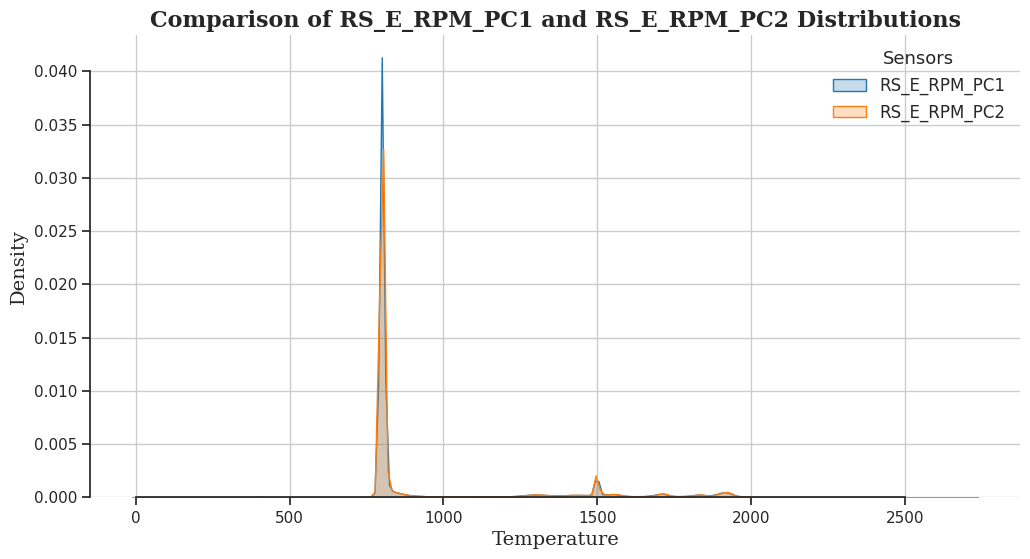

In [44]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_RPM_PC1
sns.kdeplot(data['RS_E_RPM_PC1'], fill=True, color="#1f77b4", label='RS_E_RPM_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_RPM_PC2
sns.kdeplot(data['RS_E_RPM_PC2'], fill=True, color="#ff7f0e", label='RS_E_RPM_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_RPM_PC1 and RS_E_RPM_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

the graph becomes more reasonable, but we can see a lot of data distributed around 800 RPM, after surveyed we found that:

"The trains would often be difficult or impossible to start (after having stood still for a night). As a solution, they are left running all night or are started very early. The engines make a lot of noise and therefore cause great dissatisfaction among residents of the sidings where these trains are located. For example, in 2018, local residents from Geraardsbergen sent a letter of complaint to NMBS to resolve this problem.[5]"

https://nl.wikipedia.org/wiki/MW41

so it may be the reason behind why the RPM is always around 800, because it is idel but the engine is still runing all over the night

# Distribution of RS_E_WatTemp_PC1 and RS_E_WatTemp_PC2

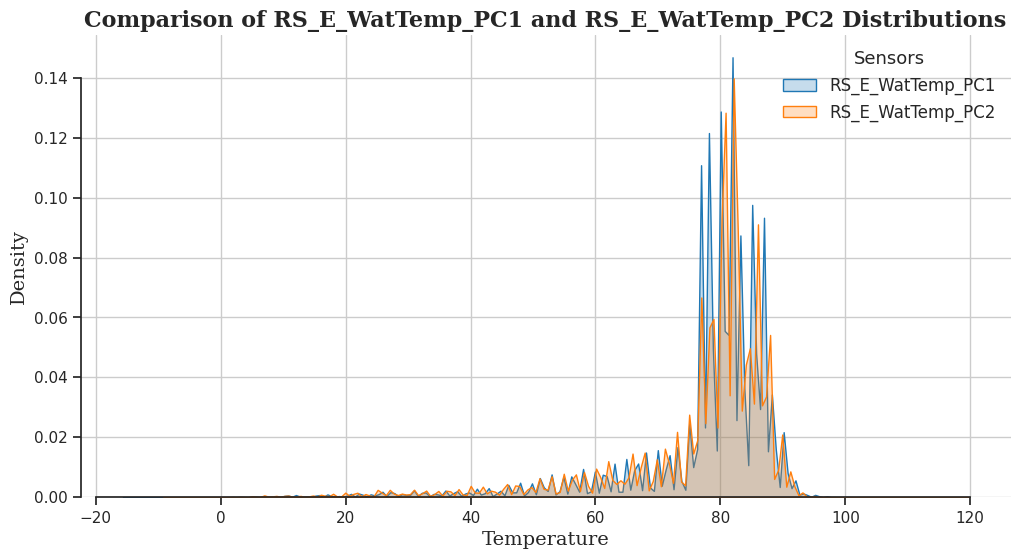

In [45]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_WatTemp_PC1
sns.kdeplot(data['RS_E_WatTemp_PC1'], fill=True, color="#1f77b4", label='RS_E_WatTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_WatTemp_PC2
sns.kdeplot(data['RS_E_WatTemp_PC2'], fill=True, color="#ff7f0e", label='RS_E_WatTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_WatTemp_PC1 and RS_E_WatTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

# Distribution of RS_T_OilTemp_PC1 and RS_T_OilTemp_PC2

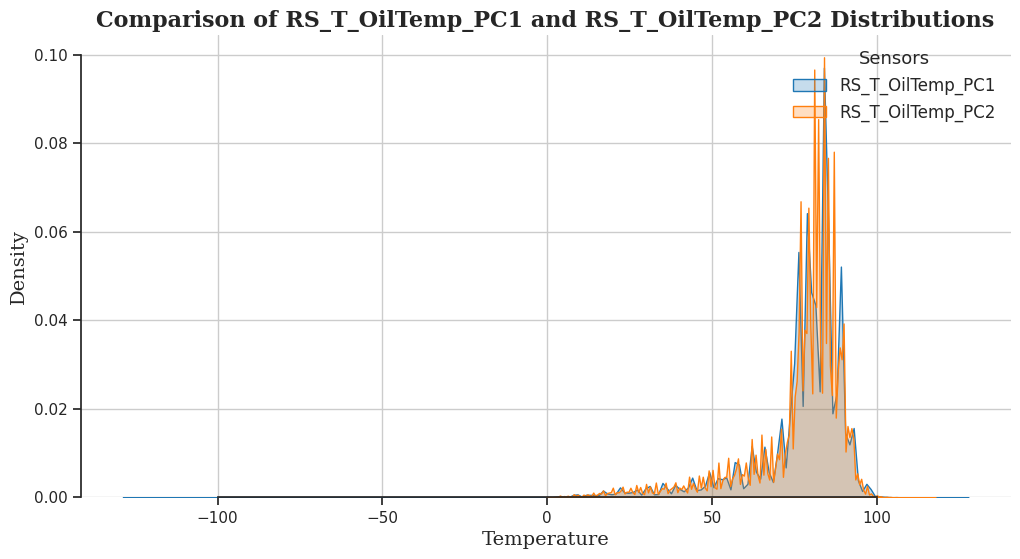

In [46]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_T_OilTemp_PC1
sns.kdeplot(data['RS_T_OilTemp_PC1'], fill=True, color="#1f77b4", label='RS_T_OilTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_T_OilTemp_PC2
sns.kdeplot(data['RS_T_OilTemp_PC2'], fill=True, color="#ff7f0e", label='RS_T_OilTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_T_OilTemp_PC1 and RS_T_OilTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

# Distribution of lon and lat

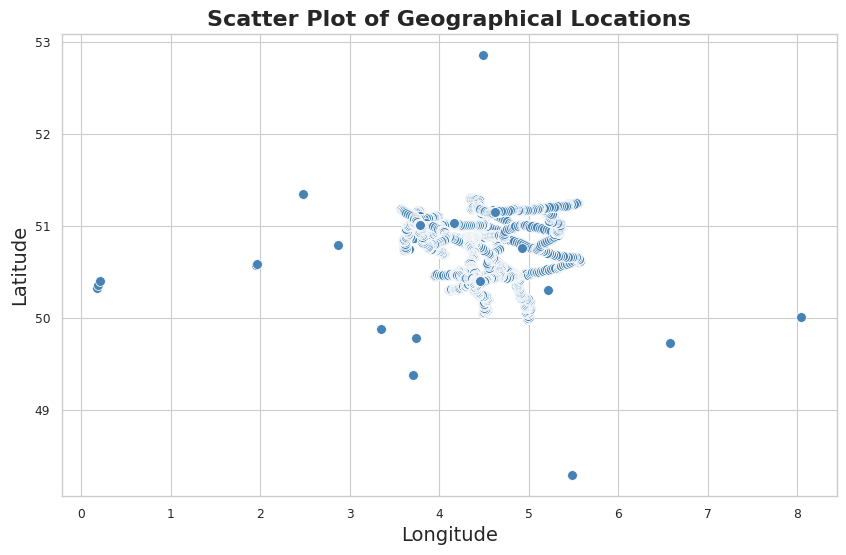

In [47]:
# Set the style of the visualization
sns.set_style("whitegrid")
sns.set_context("paper")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lon', y='lat', data=data, color='steelblue', s=50)  # s is the size of the markers

# Set title and labels with academic formatting
plt.title('Scatter Plot of Geographical Locations', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Show the plot
plt.show()

it seems there exists some outliers in lon and lat, let's try to remove it

In [48]:
# Make use of IQR Methodology
Q1 = data['lat'].quantile(0.25)
Q3 = data['lat'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define Outlier Boundary
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2 * IQR

# Define Outliers
outliers = data[(data['lat'] < lower_bound) | (data['lat'] > upper_bound)]

outliers['lat']

16944893    48.295677
16947329    49.780084
16948065    49.881053
17010854    49.729545
17033006    49.383591
17060106    52.857059
Name: lat, dtype: float64

In [49]:
# Filtering out the outliers directly without using the .drop() method
data = data[~((data['lat'] < lower_bound) | (data['lat'] > upper_bound))]
data.shape

(17677345, 18)

In [50]:
# Make use of IQR Methodology
Q1 = data['lon'].quantile(0.25)
Q3 = data['lon'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define Outlier Boundary
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1.5 * IQR

# Define Outliers
outliers = data[(data['lon'] < lower_bound) | (data['lon'] > upper_bound)]

outliers['lon']

16947299    8.045492
16994788    2.474403
17094105    2.872149
17094106    1.954037
17094108    1.960787
17094116    0.175049
17094118    0.190611
17094121    0.206793
Name: lon, dtype: float64

In [51]:
# Filtering out the outliers directly without using the .drop() method
data = data[~((data['lon'] < lower_bound) | (data['lon'] > upper_bound))]
data.shape

(17677337, 18)

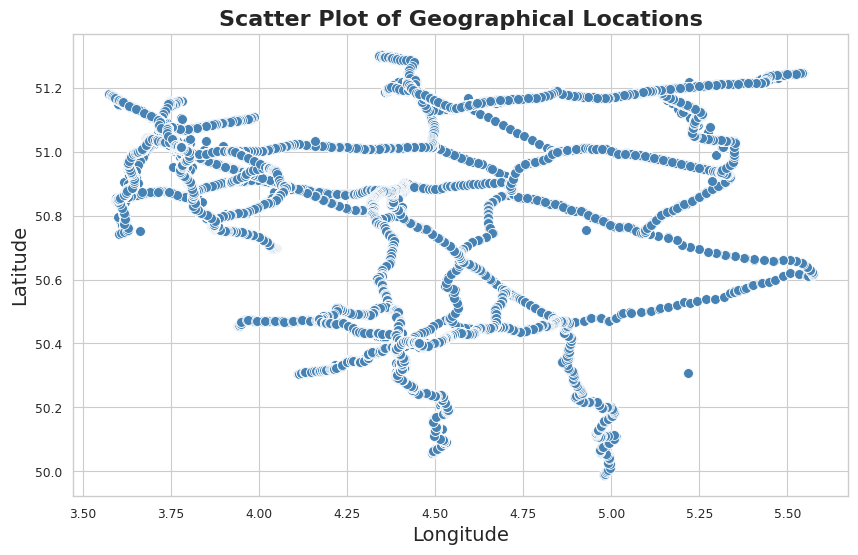

In [52]:
# Set the style of the visualization
sns.set_style("whitegrid")
sns.set_context("paper")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lon', y='lat', data=data, color='steelblue', s=50)  # s is the size of the markers

# Set title and labels with academic formatting
plt.title('Scatter Plot of Geographical Locations', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Show the plot
plt.show()

# Remove Duplicate Rows

In [53]:
print(data.shape)

(17677337, 18)


In [54]:
data.drop_duplicates(inplace=True)

In [55]:
print(data.shape)

(17677337, 18)


no duplicate was found, move on

# Set the data index

In [56]:
# Set 'timestamps_UTC' as the index
data.set_index('timestamps_UTC', inplace=True)

# Save Cleaned Data as a new Dataset

In [57]:
data.to_csv('cleaned_ar41_for_ulb.csv', index=True)